In [3]:
from rdkit import Chem
from rdkit import rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

# 1 SMILES Diversity Presentation

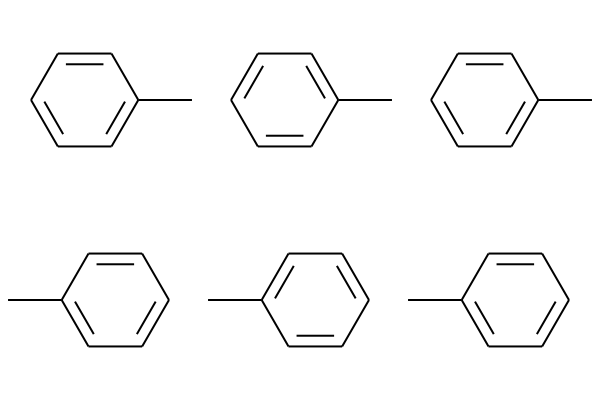

In [4]:
# Toluene

smis = 'Cc1ccccc1 c1ccccc1C c1(C)ccccc1 c1c(C)cccc1 c1cc(C)ccc1 c1ccc(C)cc1 c1cccc(C)c1'
smis = smis.split()
mols = [Chem.MolFromSmiles(smi) for smi in smis if Chem.MolFromSmiles(smi)]

img = Draw.MolsToGridImage(
    mols[:6],
    molsPerRow=3,
    subImgSize=(200, 200),
    # legends=['Toluene' for x in mols],
    returnPNG=False,
)

img.save('/pubhome/xzhang02/git/RL-gan/heteroencoder_evaluation/Toluene_6.png')
img

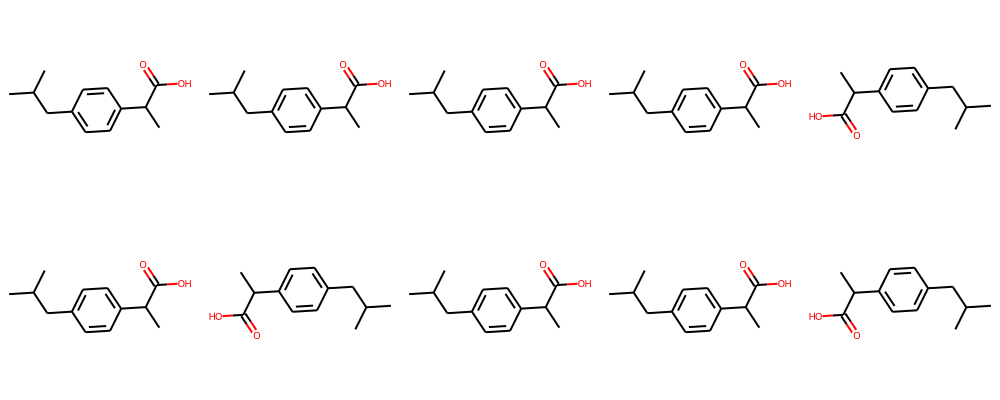

In [4]:
# Ibuprofen

smis = 'c1c(CC(C)C)ccc(C(C)C(O)=O)c1 c1(CC(C)C)ccc(C(C(=O)O)C)cc1 CC(C)Cc1ccc(C(C)C(O)=O)cc1 C(c1ccc(C(C)C(O)=O)cc1)C(C)C c1cc(C(C(=O)O)C)ccc1CC(C)C CC(Cc1ccc(C(C)C(O)=O)cc1)C c1cc(C(C)C(=O)O)ccc1CC(C)C C(c1ccc(C(C)C(=O)O)cc1)C(C)C CC(C)Cc1ccc(C(C)C(O)=O)cc1 c1c(C(C(=O)O)C)ccc(CC(C)C)c1'
smis = smis.split()
mols = [Chem.MolFromSmiles(smi) for smi in smis if Chem.MolFromSmiles(smi)]

img = Draw.MolsToGridImage(
    mols[:],
    molsPerRow=5,
    subImgSize=(200, 200),
    # legends=['Ibuprofen' for x in mols],
    returnPNG=False,
)

img

In [4]:
def judge2smi(smi1, smi2):
    """Determine whether two smiles represent the same molecule
    Args:
        smi1 (str): a molecular smiles.
        smi1 (str): a molecular smiles.
    Returns:
        result (bool): if two smiles represent the same molecule, return True, else False.
    """
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    if (mol1 is None) or (mol2 is None):
        return False
    return Chem.MolToSmiles(mol1) == Chem.MolToSmiles(mol2)

In [5]:
rdBase.DisableLog("rdApp.*")
for i in range(len(smis)):
    for j in range(i+1, len(smis)):
        if not judge2smi(smis[i], smis[j]):
            print(i, j)
rdBase.EnableLog("rdApp.*")


# 2 Heteroencoder Test Using ChEMBL Dataset 

## 2.1 data and model load

In [7]:
from rdkit import Chem
import json
import pandas as pd
import h5py
import numpy as np
import pandas as pd 
import json
import os, sys
from tqdm import trange

In [8]:
dataset_name = "/pubhome/xzhang02/GAN/modified/mol-wgan-gp/data/ChEMBL/CHEMBL25_TEST_MOLS.h5"

dataset = h5py.File(dataset_name, "r")
mols = dataset["mols"][:]
dataset.close()

CHEMBL25_smiles = [Chem.MolToSmiles(Chem.Mol(mol)) for mol in mols]


149679
CC(C)(CCCCn1cnc2c1N=CNCC2O)C(=O)O


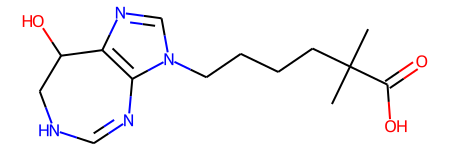

In [9]:
print(len(CHEMBL25_smiles))
index = 40000
print(CHEMBL25_smiles[index])
Chem.MolFromSmiles(CHEMBL25_smiles[index])

## 2.2 Encode and Decode

In [10]:
from ddc_pub import ddc_v3 as ddc


def load_model():
    path = os.path.join("model/heteroencoder_model")
    print("Loading heteroencoder model from:", path)
    model = ddc.DDC(model_name=path)
    return model

Using TensorFlow backend.


In [11]:
# Load model
model = load_model()

Loading heteroencoder model from: model/heteroencoder_model
Initializing model in test mode.
Loading model.
Loading finished in 18 seconds.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Inputs (InputLayer)     (None, 143, 35)      0                                            
__________________________________________________________________________________________________
mol_to_latent_model (Model)     (None, 512)          3226112     Encoder_Inputs[0][0]             
__________________________________________________________________________________________________
Decoder_Inputs (InputLayer)     (None, 142, 35)      0                                            
__________________________________________________________________________________________________
latent_to_states_model (Model)  [(None, 512), (None

In [12]:
# Encode
mols_in = [Chem.rdchem.Mol.ToBinary(Chem.MolFromSmiles(smiles)) for smiles in CHEMBL25_smiles]
latent = model.transform(model.vectorize(mols_in))
print(f'latent shape: {latent.shape}')

latent shape: (149679, 1, 512)


In [13]:
# Decode
invalids = 0
batch_size = 256    # decoding batch size
n = len(latent)
smile_origin = []
smile_decoded = []

rdBase.DisableLog("rdApp.*")

for indx in range(0, n // batch_size):
    lat = np.array(latent[(indx) * 256:(indx + 1) * 256])
    smile_origin_batch = CHEMBL25_smiles[(indx) * 256:(indx + 1) * 256]
    if indx % 10 == 0:
        print("Batch [%d/%d] decoded, [Invalids: %s]" % (indx, n // batch_size + 1, invalids))
        sys.stdout.flush()

    try:    
        smiles, _ = model.predict_batch(lat, temp=0)
        smile_origin += smile_origin_batch
        smile_decoded += list(smiles)
        for smi in smiles:
            mol = Chem.MolFromSmiles(smi)
            if not mol:
                invalids += 1
    except Exception as e:
        print(e)
        continue
    
print("Decoding completed.")
n = len(smile_decoded)
print("Total: [%d] Fraction Valid: [0.%d]" % (n, (n - invalids) / n * 100))

rdBase.EnableLog("rdApp.*")



Batch [0/585] decoded, [Invalids: 0]
Batch [10/585] decoded, [Invalids: 41]
Batch [20/585] decoded, [Invalids: 100]
Batch [30/585] decoded, [Invalids: 140]
Batch [40/585] decoded, [Invalids: 183]
Batch [50/585] decoded, [Invalids: 229]
Batch [60/585] decoded, [Invalids: 269]
Batch [70/585] decoded, [Invalids: 317]
Batch [80/585] decoded, [Invalids: 369]
Batch [90/585] decoded, [Invalids: 415]
Batch [100/585] decoded, [Invalids: 466]
Batch [110/585] decoded, [Invalids: 514]
Batch [120/585] decoded, [Invalids: 553]
Batch [130/585] decoded, [Invalids: 588]
Batch [140/585] decoded, [Invalids: 632]
Batch [150/585] decoded, [Invalids: 681]
Batch [160/585] decoded, [Invalids: 729]
Batch [170/585] decoded, [Invalids: 766]
Batch [180/585] decoded, [Invalids: 809]
Batch [190/585] decoded, [Invalids: 860]
Batch [200/585] decoded, [Invalids: 920]
Batch [210/585] decoded, [Invalids: 968]
Batch [220/585] decoded, [Invalids: 1022]
Batch [230/585] decoded, [Invalids: 1074]
Batch [240/585] decoded, [In

In [14]:
print(len(smile_origin), len(smile_decoded))
print(smile_origin[0], '\n', smile_decoded[0])

149504 149504
Cc1ccc(C2NC(=O)c3ccccc3N2)c(C)c1 
 c1ccc2c(c1)NC(c1ccc(C)cc1C)NC2=O


In [15]:
def judge2smi(smi1, smi2):
    """Determine whether two smiles represent the same molecule
    Args:
        smi1 (str): a molecular smiles.
        smi1 (str): a molecular smiles.
    Returns:
        result (bool): if two smiles represent the same molecule, return True, else False.
    """
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    if (mol1 is None) or (mol2 is None):
        return False
    return Chem.MolToSmiles(mol1) == Chem.MolToSmiles(mol2)

In [16]:
rdBase.DisableLog("rdApp.*")

same = 0
for index in trange(len(smile_decoded)):
    if judge2smi(smile_origin[index], smile_decoded[index]):
        same += 1

rdBase.EnableLog("rdApp.*")

print('\n\nThe ratio of reconstruction correctness is {:.2%}'.format(same/len(smile_decoded)))

100%|██████████| 149504/149504 [01:17<00:00, 1921.17it/s]

The ratio of reconstruction correctness is 74.05%

